In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Colab Notebooks/Github/SindyAutoencoders_project

/content/drive/My Drive/Colab Notebooks/Github/SindyAutoencoders_project


In [36]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow as tf
import os
from robi.example_spring import get_spring_data, spring_to_movie, generate_spring_data
from scipy.integrate import odeint, solve_ivp
from src.autoencoder import full_network
from src.training import create_feed_dictionary
from src.sindy_utils import sindy_simulate_order2

In [39]:
params_f = {'c':0.33, 'm':0.5, 'k':1}
spring_f = lambda t, x: [x[1], -params_f['c']*x[1]-(params_f['k']/params_f['m'])*x[0]]

dt = .01
t = np.arange(0, 20, dt)

#vary c to change the damping behaviour 


z0 = [1, 0]

z_train = solve_ivp(spring_f, 
                    t_span = (t[0], t[-1]), 
                    y0 = z0,
                    t_eval = t).y.T

# dz_train = np.array([spring_f(t[j], x_train[j], params) for j in range(len(t))])

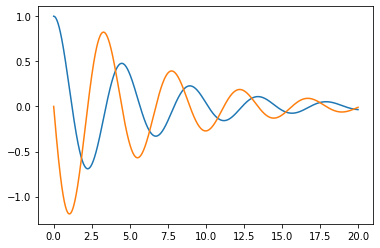

In [40]:
plt.plot(t, z_train[:,0])
plt.plot(t, z_train[:,1]) # first derivative dx

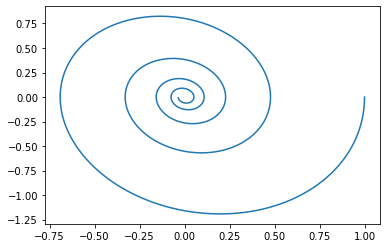

In [41]:
# ATTRACTOR for a specific initial condition (z0 = [1, 0])
plt.plot(z_train[:,0], z_train[:,1])

In [42]:
def spring_to_movie2(z, dz, n = 100):
    #n_ics = z.shape[0]
    n_samples = z.shape[0]

    y1, y2 = np.meshgrid(np.linspace(-1.5, 1.5, n), np.linspace(1.5, -1.5, n))

    # defining a gaussian over the image centered where our point mass is
    create_image = lambda x: np.exp(-((y1 - x) ** 2 + (y2 - 0) ** 2) / .05)
    d_create_image = lambda x, dx: -1 / .05 * create_image(x) * 2 * (y1 - x) * dx
    dd_create_image = lambda x, dx, ddx: (2 / .05) * (d_create_image(x, dx) * (y1 - x) * dx + create_image(x) * (- dx * dx + (y1 - x) * ddx))

    x = np.zeros((n_samples, n, n))
    dx = np.zeros((n_samples, n, n))
    ddx = np.zeros((n_samples, n, n))
    for j in range(n_samples):
        x[j] = create_image(z[j, 0])
        dx[j] = d_create_image(z[j, 0], dz[j, 0])
        ddx[j] = dd_create_image(z[j, 0], dz[j, 0], dz[j, 1])
    return x, dx, ddx

In [46]:
dz_train = np.array([spring_f(t[j], z_train[j]) for j in range(len(t))])
x_train,dx_train,ddx_train = spring_to_movie2(z_train, dz_train)

Text(0.5, 1.0, 'ddz')

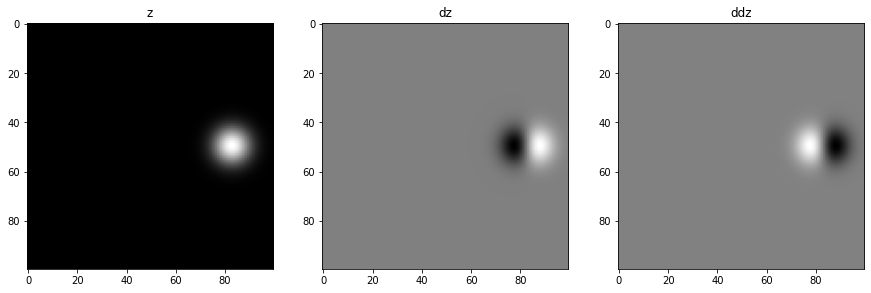

In [48]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

i = 2
ax[0].imshow(x_train[i], cmap = "gray")
#ax[0].axis('off')
ax[0].set_title('z')

ax[1].imshow(dx_train[i], cmap = "gray")
#ax[1].axis('off')
ax[1].set_title('dz')

ax[2].imshow(ddx_train[i], cmap = "gray")
#ax[2].axis('off')
ax[2].set_title('ddz')

In [ ]:
# images are the higher dimensional dataset from which we derive the lower dimensional representation of the coordinates

### Evaluate the obtained model (from the training) on a test set

In [ ]:
# get the parameters obtained from the training of the sindy autoencoder NN
data_path = os.getcwd() + '/'
save_name = 'model1'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name

autoencoder_network = full_network(params)
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

In [29]:
# and evaluate the latent varibles z(t) given one initial condition
test_data = generate_spring_data(1)
test_data = {}
test_data['x'] = test_data['x'].reshape((-1,params['input_dim']))
test_data['dx'] = test_data['dx'].reshape((-1,params['input_dim']))
test_data['ddx'] = test_data['ddx'].reshape((-1,params['input_dim']))
test_data['z'] = test_data['z'].reshape((-1,params['latent_dim']))
test_data['dz'] = test_data['dz'].reshape((-1,params['latent_dim']))
test_data['ddz'] = test_data['ddz'].reshape((-1,params['latent_dim']))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

true_coefficients = np.zeros(test_set_results['sindy_coefficients'].shape)
# SETTARE I VERI PARAMETRI UNA VOLTA CHE OTTENGO LE DIMENSIONI DI test_set_results['sindy_coefficients']
true_coefficients[-2] = -1. ##### CAMBIARE #####

n_ics = 1
z_sim = np.zeros((n_ics, t.size, 2))
spring_sim = np.zeros(z_sim.shape)
for i in range(n_ics):
    z_sim[i] = sindy_simulate_order2(test_set_results['z'][i*t.size], test_set_results['dz'][i*t.size], t,
                                     params['coefficient_mask']*test_set_results['sindy_coefficients'],
                                     params['poly_order'], params['include_sine'])
    spring_sim[i] = sindy_simulate_order2(test_data['z'][i*t.size], test_data['dz'][i*t.size], t,
                                            true_coefficients,
                                            params['poly_order'], params['include_sine'])

In [ ]:
# PLOT THE ATTRACTOR IN THE PREDICTED CASE (with predicted coefficients) AND IN THE SIMULATED CASE (with true coefficients)
plt.figure(figsize=(4,3))
plt.plot(z_sim[:,:,0].T, z_sim[:,:,1].T, linewidth=2, color='#2071B1')
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

plt.figure(figsize=(4,3))
plt.plot(spring_sim[:,:,0].T, spring_sim[:,:,1].T, linewidth=2, color='#2071B1')
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

In [ ]:
# plot the trajectory of the latent variable z(t) considering one initial condition
ic_idx = 1 

plt.figure(figsize=(3,2))
plt.subplot(2,1,1)
plt.plot(test_set_results['z'][ic_idx*t.size:(ic_idx+1)*t.size,0], 'k', color='#888888', linewidth=2)
plt.plot(z_sim[ic_idx,:,0], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

In [ ]:
# evaluate the results of the test set on several initial conditions
test_data = get_spring_data(10)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_ddx_error = np.mean((test_data['ddx'] - test_set_results['ddx_decode'])**2)/np.mean(test_data['ddx']**2)
sindy_ddz_error = np.mean((test_set_results['ddz'] - test_set_results['ddz_predict'])**2)/np.mean(test_set_results['ddz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_ddx_error)
print('SINDy reltive error, z: %f' % sindy_ddz_error)

In [ ]:
!git add .
!git commit -m "Evaluating the model (still have to run it since I miss the model parameters)"

In [ ]:
!git push